In [21]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [22]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [23]:
IM_SHAPE=(225,225)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [24]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    '../input/covidog/dataset',
    target_size=IM_SHAPE,

    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '../input/covidnew/ALL', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= val_datagen.flow_from_directory(
    '../input/covidnew/ALL',
    batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE,
    shuffle=False
)

Found 269 images belonging to 2 classes.
Found 15861 images belonging to 2 classes.
Found 6796 images belonging to 2 classes.


In [25]:
#from keras.applications import DenseNet121


vgg = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

In [26]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fe6445fc210>,input_3,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7fe6449b9e10>,zero_padding2d_4,False
2,<keras.layers.convolutional.Conv2D object at 0x7fe6445fc910>,conv1/conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe6443aa290>,conv1/bn,False
4,<keras.layers.core.Activation object at 0x7fe6449b9fd0>,conv1/relu,False
...,...,...,...
423,<keras.layers.convolutional.Conv2D object at 0x7fe63c705a90>,conv5_block16_2_conv,False
424,<keras.layers.merge.Concatenate object at 0x7fe63c70de10>,conv5_block16_concat,False
425,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe63d7fff90>,bn,False
426,<keras.layers.core.Activation object at 0x7fe63c73b8d0>,relu,False


In [27]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


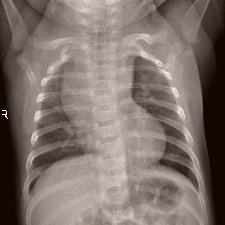

In [28]:
array_to_img(train_generator[0][0][0])

(32, 7, 7, 1024)


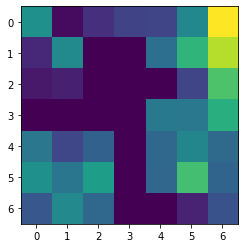

In [29]:
bottleneck_feature_example = vgg.predict(train_generator[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [30]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(4096, activation='relu')) 
#model.add(Dropout(0.25)) 
model_TF.add(Dense(2048, activation='relu')) 
#model.add(Dropout(0.25))
model_TF.add(Dense(1024, activation='relu')) 
#model.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))



model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [31]:
history_TF = model_TF.fit_generator(train_generator_NEW, 
                              epochs=10,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


496/496 [==============================] - 125s 243ms/step - loss: 0.2450 - accuracy: 0.9019 - f1_m: 0.8705 - precision_m: 0.9371 - recall_m: 0.8179 - val_loss: 0.1250 - val_accuracy: 0.9528 - val_f1_m: 0.9427 - val_precision_m: 0.9716 - val_recall_m: 0.9175
Epoch 2/10
496/496 [==============================] - 85s 171ms/step - loss: 0.1182 - accuracy: 0.9544 - f1_m: 0.9414 - precision_m: 0.9717 - recall_m: 0.9142 - val_loss: 0.1095 - val_accuracy: 0.9588 - val_f1_m: 0.9475 - val_precision_m: 0.9705 - val_recall_m: 0.9276
Epoch 3/10
496/496 [==============================] - 86s 173ms/step - loss: 0.0814 - accuracy: 0.9688 - f1_m: 0.9615 - precision_m: 0.9802 - recall_m: 0.9442 - val_loss: 0.1093 - val_accuracy: 0.9575 - val_f1_m: 0.9529 - val_precision_m: 0.9691 - val_recall_m: 0.9385
Epoch 4/10
496/496 [==============================] - 82s 166ms/step - loss: 0.0534 - accuracy: 0.9800 - f1_m: 0.9732 - precision_m: 0.9894 - recall_m: 0.9581 - val_loss: 0.1182 - val_accuracy: 0.9567 - 

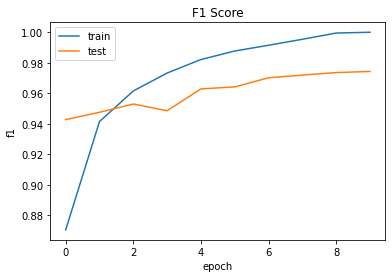

In [32]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
dense = tf.keras.applications.DenseNet121(include_top=False,  
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [34]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(4096, activation='relu')) 
#model.add(Dropout(0.25)) 
model.add(Dense(2048, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 50176)             7037504   
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              205524992 
_________________________________________________________________
dense_13 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 2050      
Total params: 223,053,378
Trainable params: 222,969,730
Non-trainable params: 83,648
_________________________________________________________________


In [36]:
history = model.fit_generator(train_generator_NEW, 
                              epochs=10,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/10
496/496 [==============================] - 142s 268ms/step - loss: 0.1340 - accuracy: 0.9487 - f1_m: 0.9309 - precision_m: 0.9674 - recall_m: 0.9047 - val_loss: 0.0482 - val_accuracy: 0.9823 - val_f1_m: 0.9711 - val_precision_m: 0.9936 - val_recall_m: 0.9513
Epoch 2/10
496/496 [==============================] - 139s 280ms/step - loss: 0.0300 - accuracy: 0.9885 - f1_m: 0.9851 - precision_m: 0.9947 - recall_m: 0.9761 - val_loss: 0.0503 - val_accuracy: 0.9831 - val_f1_m: 0.9778 - val_precision_m: 0.9885 - val_recall_m: 0.9680
Epoch 3/10
496/496 [==============================] - 149s 301ms/step - loss: 0.0151 - accuracy: 0.9951 - f1_m: 0.9925 - precision_m: 0.9979 - recall_m: 0.9873 - val_loss: 0.0473 - val_accuracy: 0.9856 - val_f1_m: 0.9838 - val_precision_m: 0.9903 - val_recall_m: 0.9779
Epoch 4/10
496/496 [==============================] - 136s 274ms/step - loss: 0.0082 - accuracy: 0.9972 - f1_m: 0.9965 - precision_m: 0.9985 - recall_m: 0.9946 - val_loss: 0.0388 - val_accur

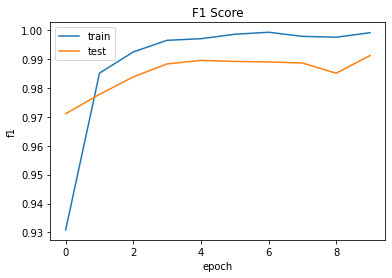

In [37]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()